In [1216]:
%load_ext rpy2.ipython
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import (LogisticRegression, LinearRegression, RidgeClassifier, Lasso, RandomizedLasso)
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.model_selection import cross_val_score,ShuffleSplit,GridSearchCV
from sklearn.metrics import roc_auc_score,roc_curve, auc
from sklearn.feature_selection import RFE
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from tpot import TPOTClassifier


In [1217]:
# load dataset and choose 'model'
path_dataset = "mdl_data.csv"
data=pd.read_csv(path_dataset)

choice=1
print('shape before: ',data.shape)
if (choice == 1):   # triage model
    data=data.iloc[:,0:41]   
elif (choice == 2): #after model
    data=data.iloc[:,list(range(0, 11))+list(range(41, 67))]
else: 
    #data = data[['death', 'evd_ct', 'age', 'temp_triage', 'headache_triage', 'hemorrhage_triage','diarrhea_triage','jaundice_triage','vomiting_triage','abdomnial_triage','asthenia_triage']]
    data = data[['death', 'evd_ct', 'disorientation_triage', 'jaundice_triage', 'headache_triage', 'days_admitted']]




shape before:  (575, 67)


In [1218]:
#small tests
print(data.shape)



(575, 41)


# Helper function

In [1219]:

def repeatedCV (model, dataFeatures,dataOutcome):
    maxloop = 100
    splitsnb= 10
    testproportion =0.25
    results= []
    for k in range(maxloop):
        lecv = ShuffleSplit(n_splits=splitsnb, test_size= testproportion,random_state=1)
        results.append(cross_val_score(model, dataFeatures, dataOutcome, scoring='accuracy', cv=lecv))
    return results

#  Preprocessing and feature engineering


In [1220]:
#Preprocessing
#trainfile= 'trainSinaModel.csv'
#testfile= 'testSinaModel.csv'

# we remove all patients with missing evd_ct. 
#2 possible causes: {1. evd- (No ebola->no death prediction) (417 cases) 2. Unknown (14 cases)} 
data=data[np.isfinite(data['evd_ct'])] 



#data=data.dropna() # Dropping from 575 to 118!!
data=data.fillna(round(data.mean())) #Should round to not loose binary format of columns!
print('shape after: ', data.shape)

ytrue=data['death']
if choice==3:
    X=data.drop(['death','evd'],axis=1) #'study_id' could also be added to be droped
else:
    X=data.drop(['death','study_id','evd'],axis=1) #'study_id' could also be added to be droped



       
 #the only columns wirh missing info: ,'malaria','referral_time',evd_ct' (removed higher),'quarantine'(removed by first two)
print('Missing values: \n' ,pd.isnull(X).values.any(), np.where(pd.isnull(X)))


headers = X.dtypes.index

#scaler = StandardScaler()
#X= scaler.fit_transform(X)

#Creating two separate files for training and validation. CV will only be done on training set
# Validation set will be only used for testing: real unseen data
# we prefer more training simples with y=1 so we don't use stratify=ytrue because it decreases it
X_train, X_test, y_train, y_test = train_test_split(X, ytrue, test_size=0.25, random_state=10)
print(y_train.value_counts()) # ytrue: 86 nondeath (60%) and 58 deaths
#pd.concat([y_train, X_train], axis=1).to_csv(path_or_buf= trainfile)
#pd.concat([y_test, X_test], axis=1).to_csv(path_or_buf= testfile)



shape after:  (144, 41)
Missing values: 
 False (array([], dtype=int64), array([], dtype=int64))
1    64
0    44
Name: death, dtype: int64


# TPOT

In [1221]:
pipeline_optimizer = TPOTClassifier(generations=5, population_size=20, cv=5,
                                    random_state=1, verbosity=2)
#pipeline_optimizer.fit(X_train, y_train)
#print(pipeline_optimizer.score(X_test, y_test))
#pipeline_optimizer.export('tpot_exported_pipeline.py')


#tpotmodel = LogisticRegression(C=0.1, dual=False, penalty="l2")
tpotmodel= LinearSVC(C=0.01)
tpotmodel.fit(X_train, y_train)
results = tpotmodel.predict(X_test)
print('sss:',roc_auc_score(y_test, results))

Version 0.7.1 of tpot is outdated. Version 0.7.2 was released 17 hours ago.
sss: 0.883116883117


# Logistic Regression

In [1227]:
# instantiate a logistic regression model, and fit with X and y
# we prefer have false positives than false negatives. So we want high recall for death=1
#model = LogisticRegression(class_weight={0:.25, 1:.75})
risk_threshold=0.50
model = LogisticRegression()
#model = LogisticRegression(class_weight="balanced") #replicating the smaller class until you have as many samples as in the larger one, but in an implicit way.
scores = cross_val_score(model, X, ytrue, scoring='accuracy', cv=10) #scoring='roc_auc'    
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

#Repeated K fold with random shuffling
#results= repeatedCV(model, X_train,y_train)
#print('repeated K folds- mean: ',np.mean(results),' +/- ',np.std(results) *2)
# check the accuracy on the training set


#Single fold
print('\nSingle fold:\n  ')
#model.fit(X_train, y_train)

param_grid = { 
    'C': [0.001, 0.01, 0.1,0.3,0.35,0.4,0.45, 0.5, 0.55, 0.6, 0.7, 1, 10, 100, 1000],
    'penalty' :['l1','l2'],
    #'class_weight': [{0:.25, 1:.75}, {0:.5, 1:.5}, {0:.3, 1:.7}, {0:.4, 1:.6}   ]
}

CV_LR = GridSearchCV(estimator=model,scoring='roc_auc', param_grid=param_grid, cv= 10)
CV_LR.fit(X_train, y_train)
print('best parameters from grid search' ,CV_LR.best_params_, ' , best score:', CV_LR.best_score_)
probs=  CV_LR.predict_proba(X_test)
y_pred = [int(risk_threshold < p[1]) for p in probs]


#print(probs)




print('simple LR : ',CV_LR.score(X_test, y_test),'auc: ',roc_auc_score(y_test, y_pred))
print('RMSE: ', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print('Matthew Correlation coefficient',sklearn.metrics.matthews_corrcoef(y_test,y_pred))


Accuracy: 0.85 (+/- 0.15)

Single fold:
  
best parameters from grid search {'penalty': 'l2', 'C': 0.35}  , best score: 0.93602292769
simple LR :  0.918831168831 auc:  0.86038961039
RMSE:  0.37267799625
[[12  2]
 [ 3 19]]
             precision    recall  f1-score   support

          0       0.80      0.86      0.83        14
          1       0.90      0.86      0.88        22

avg / total       0.86      0.86      0.86        36

Matthew Correlation coefficient 0.71272556889


(36,)


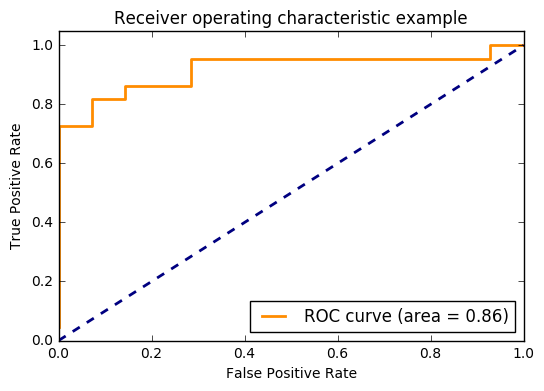

In [1244]:
print(probs[:,0].shape)
fpr,tpr, _ = roc_curve(y_test,probs[:,1])
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, y_pred))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
plt.figure()
plt.title("One informative feature, one cluster per class", fontsize='small')
X1, Y1 = make_classification(n_features=2, n_redundant=0, n_informative=1,
                             n_clusters_per_class=1)
plt.scatter(X1[:, 0], X1[:, 1], marker='o', c=Y1)
plt.show()

In [ ]:
%%R
library(ggplot2)

ggplot(df) +
  geom_bar(aes(Sex), stat = "bin") + 
  geom_bar(aes(Sex, fill = factor(Survived)), stat = "bin", position = "dodge") +
  scale_fill_manual(values=c("#DD3333", "#33CC66", "#eeee00"))

# Feature selection through RFE and Randomized Lasso

In [1197]:
#rank all features, i.e continue the elimination until the last 3
rfe = RFE(model, 5) #recursive feature elimination, 
rfe = rfe.fit(X, ytrue)
# summarize the selection of the attributes
print(headers[rfe.support_ == True])
#print(rfe.support_)
#print(rfe.ranking_)

print('\nRandomized Lasso \n')
rlasso = RandomizedLasso(alpha=0.0001)
rlasso.fit(X, ytrue)
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rlasso.scores_), 
                 headers), reverse=True))



Index(['disorientation_after', 'headache_after', 'abdominal_after',
       'diarrhea_score_after', 'hemorrhage_after'],
      dtype='object')

Randomized Lasso 

Features sorted by their score:
[(1.0, 'quarantine'), (1.0, 'evd_ct'), (1.0, 'disorientation_after'), (1.0, 'diarrhea_score_after'), (1.0, 'days_admitted'), (1.0, 'conjunctivitis_after'), (1.0, 'age'), (0.98999999999999999, 'referral_time'), (0.98499999999999999, 'abdominal_after'), (0.97999999999999998, 'myalgia_after'), (0.97499999999999998, 'hepatomegaly_after'), (0.96999999999999997, 'dehydration_after'), (0.95999999999999996, 'asthenia_after'), (0.95499999999999996, 'edema_after'), (0.94999999999999996, 'dyspnea_after'), (0.93500000000000005, 'malaria'), (0.93500000000000005, 'jaundice_after'), (0.92000000000000004, 'headache_after'), (0.91500000000000004, 'hiccups_after'), (0.91000000000000003, 'gyne_hemorrhage_after'), (0.91000000000000003, 'date_admis'), (0.90500000000000003, 'rash_after'), (0.90500000000000003, 'orl_h

# Feature selection through random forest

Feature ranking:
1. feature 5 days_admitted (0.163869)
2. feature 10 disorientation_after (0.134412)
3. feature 0 evd_ct (0.093214)
4. feature 3 age (0.069157)
5. feature 21 hemorrhage_after (0.057866)
6. feature 19 diarrhea_score_after (0.038068)
7. feature 11 headache_after (0.037350)
8. feature 6 referral_time (0.032501)
9. feature 7 date_admis (0.028990)
10. feature 23 conjunctivitis_after (0.025785)
11. feature 17 abdominal_after (0.023530)
12. feature 29 dehydration_after (0.023320)
13. feature 28 num_hemorrhage_sites_after (0.022769)
14. feature 4 quarantine (0.022302)
15. feature 2 sex (0.021451)
16. feature 18 anorexia_after (0.020881)
17. feature 22 orl_hemorrhage_after (0.020460)
18. feature 15 dysphagia_after (0.019693)
19. feature 12 hiccups_after (0.018637)
20. feature 1 malaria (0.016861)
21. feature 9 dyspnea_after (0.014310)
22. feature 8 anuria_after (0.012704)
23. feature 20 vomiting_after (0.012131)
24. feature 32 edema_after (0.011329)
25. feature 30 hepatomegaly_a

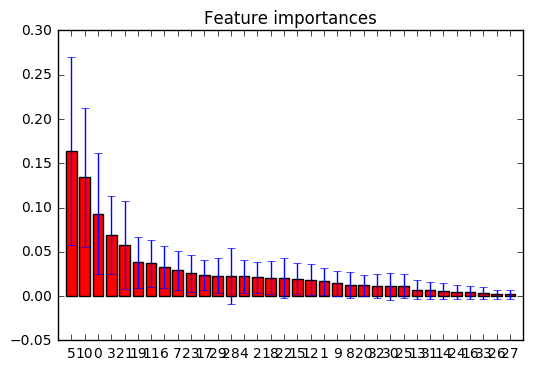

In [1198]:
forest = ExtraTreesClassifier(n_estimators=250, #The number of trees in the forest
                              random_state=1)   #max_features: If “auto”, then max_features=sqrt(n_features).

forest.fit(X, ytrue)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], headers[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

# Other linear models

In [1245]:
import math
from sklearn.linear_model import RidgeCV


bestalpha=0
lastBestscore= math.inf
for k in range(5000):
    ridge = RidgeClassifier(alpha=k*.1)
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_test)
    if k > 1 and RMSE < np.sqrt(metrics.mean_squared_error(y_test, y_pred)): #exit when RMSE don't decrease
        break
    RMSE= np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    if RMSE < lastBestscore:
        lastBestscore= RMSE
        #print('k: ',k, "Ridge: ",ridge.score(X_test,y_test), 'RMSE: ', RMSE)
        bestalpha= k*.1

print('Best alpha: ',bestalpha)

#Another Ridge Classifier, this time with 

#ridgecv = LogisticRegression(C=0.1, dual=False, penalty="l2")
ridgecv = RidgeClassifier(alpha=bestalpha)
scores = cross_val_score(ridgecv, X, ytrue, scoring='accuracy', cv=10)
print("Ridge 4Fold CV Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


######################################## CLASSS WEIGHT TO WORK ON
# reg = RidgeClassifier(class_weight={1: 0.001})

#############
 
lasso = Lasso(alpha=0.0005)
lasso.fit(X, ytrue)
print("Lasso: ",lasso.score(X, ytrue))
print("Lasso model: ", lasso.coef_)


#svc = svm.SVC(kernel='linear') #SVM overfits easily with few data and lots of features
svc= LinearSVC(C=0.01,tol=1e-05)
svc.fit(X_train, y_train)
print('svm score: ', svc.score(X_test,y_test))
print(confusion_matrix(y_test,svc.predict(X_test)),classification_report(y_test,svc.predict(X_test)))
 

Best alpha:  0.5
Ridge 4Fold CV Accuracy: 0.83 (+/- 0.15)
Lasso:  0.578721966974
Lasso model:  [-0.02409876  0.09985681  0.02141159  0.00398069  0.13491168 -0.04486198
 -0.02802766 -0.00296    -0.01380808  0.07033387  0.28785321  0.07493042
  0.10108869 -0.14797152  0.09638598 -0.03798134 -0.28094614  0.05499854
 -0.04127287 -0.08834811 -0.05667383  0.05846907  0.00496281 -0.009185
  0.06681236 -0.05615854  0.02402541  0.01791827  0.10685995  0.02548182
 -0.07640686 -0.         -0.09917132  0.07892607  0.18715794  0.          0.
 -0.35655217]
svm score:  0.888888888889
[[12  2]
 [ 2 20]]              precision    recall  f1-score   support

          0       0.86      0.86      0.86        14
          1       0.91      0.91      0.91        22

avg / total       0.89      0.89      0.89        36



# Toy Neural net

In [1139]:
# http://www.kdnuggets.com/2016/10/beginners-guide-neural-networks-python-scikit-learn.html/2
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix
X_train, X_test, y_train, y_test = train_test_split(X, ytrue, test_size=0.75, random_state=1)
scaler = StandardScaler()
# Fit only to the training data
scaler.fit(X_train)
# Now apply the transformations to the data:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
mlp = MLPClassifier(hidden_layer_sizes=(300,300,300))
mlp.fit(X_train,y_train)
predictions = mlp.predict(X_test)
print('error:',np.mean(predictions - y_test)**2)
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

error: 8.573388203017832e-05
[[28 14]
 [13 53]]
             precision    recall  f1-score   support

          0       0.68      0.67      0.67        42
          1       0.79      0.80      0.80        66

avg / total       0.75      0.75      0.75       108



In [1012]:
print(int(.5<0.88))

1
